## 앰비언트 에이전트 구축 소개

이 과정의 주요 목표는 앰비언트 에이전트의 개념과 기존 채팅 에이전트와의 차이점을 탐구하는 것입니다.

## LangGraph의 핵심 기본 사항

이 과정은 노드, 엣지, 상태 그래프와 같은 LangGraph의 핵심 기본 사항에 익숙해지도록 설계되었습니다. 이러한 요소들은 우리가 만들 이메일 에이전트의 핵심 구성 요소가 될 것입니다.

다양한 도구 및 플랫폼과의 통합 방법을 시연할 예정입니다. 여기에는 다양한 모델 제공업체와의 통합을 위한 LangChain, 관찰 가능성 및 평가를 위한 LangSmith, 배포를 위한 LangGraph 플랫폼, 시각화 및 디버깅을 위한 LangGraph Studio 사용법이 포함됩니다.

![](./assets/36051.png)

## Resources

- Notebook Reference: [langgraph_101.ipynb](https://github.com/langchain-ai/agents-from-scratch/blob/main/notebooks/langgraph_101.ipynb)
- For LangSmith Studio: [src/email_assistant](https://github.com/langchain-ai/agents-from-scratch/tree/main/src/email_assistant)
- Slides: [Building Ambient Agents with LangGraph - LangGraph 101.pdf](https://files.cdn.thinkific.com/file_uploads/967498/attachments/b9a/35b/890/Building_Ambient_Agents_with_LangGraph_-_LangGraph_101.pdf)

## 설치하기

In [21]:
%pip install -Uq langchain

Note: you may need to restart the kernel to use updated packages.


## 환경 설정

In [22]:
from dotenv import load_dotenv


load_dotenv("../../.env", override=True)

False

In [23]:
import os


os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Chat models

In [24]:
from langchain.chat_models import init_chat_model


llm = init_chat_model("openai:gpt-4.1-mini", temperature=0)

## 도구(Tools)

도구는 채팅 모델이 호출할 수 있는 유틸리티입니다. LangChain에서는 `@tool` 데코레이터를 사용하여 도구를 생성할 수 있으며, 이는 Python 함수를 호출 가능한 도구로 변환합니다. 이 데코레이터는 함수 정의로부터 도구의 이름, 설명 및 예상 인수를 자동으로 추론합니다. 또한 모델 컨텍스트 프로토콜(MCP) 서버를 LangChain 호환 도구로 사용할 수도 있습니다.

In [25]:
from langchain.tools import tool


@tool
def write_email(to: str, subject: str, content: str):
    """이메일을 작성하고 전송합니다."""
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

In [26]:
type(write_email)

langchain_core.tools.structured.StructuredTool

In [27]:
write_email.args

{'to': {'title': 'To', 'type': 'string'},
 'subject': {'title': 'Subject', 'type': 'string'},
 'content': {'title': 'Content', 'type': 'string'}}

In [28]:
write_email.description

'이메일을 작성하고 전송합니다.'

## Tool Calling

도구는 대규모 언어 모델(LLM)에 의해 호출될 수 있습니다. 도구가 모델에 바인딩되면, 모델은 도구 인자를 포함한 구조화된 출력을 반환함으로써 도구를 호출할 수 있습니다. `bind_tools` 메서드를 사용하여 대규모 언어 모델에 도구를 추가합니다.

![](assets/tool_call_detail.png)

프로바이더는 특정 도구를 호출하도록 강제하기 위해 [`tool_choice`와 같은 매개변수](https://python.langchain.com/docs/how_to/tool_choice/)를 사용할 수 있습니다. `any`는 도구 중 최소 하나를 선택합니다.

또한 [`parallel_tool_calls=False`를 설정](https://python.langchain.com/docs/how_to/tool_calling_parallel/)하여 모델이 한 번에 하나의 도구만 호출하도록 보장할 수 있습니다.

In [29]:
model_with_tools = llm.bind_tools(
    [write_email],
    tool_choice="any",
    parallel_tool_calls=False,
)

In [30]:
output = model_with_tools.invoke(
    "내일 회의에 대해 상사(boss@company.ai)에게 보낼 답변 초안을 작성해 주세요."
)

In [31]:
type(output)

langchain_core.messages.ai.AIMessage

In [32]:
output

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 78, 'total_tokens': 172, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_c064fdde7c', 'id': 'chatcmpl-CTU04cvRPmrxDoW8ptPIegI7y04GF', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--2e7b133c-0f22-4863-96fe-d733c38ce8b2-0', tool_calls=[{'name': 'write_email', 'args': {'to': 'boss@company.ai', 'subject': '내일 회의 관련 답변', 'content': '안녕하세요, 상사님.\n\n내일 회의에 대해 확인하였습니다. 준비된 자료와 안건을 바탕으로 회의에 적극 참여하겠습니다. 혹시 추가로 준비해야 할 사항이나 요청하실 내용이 있으시면 알려주시기 바랍니다.\n\n감사합니다.'}, 'id': 'call_xS7ksdMlOGcSvz1V4RHZj8BU', 'type': 'tool_call'}], usage_metadata={'input_tokens': 78, 'output_tokens':

In [33]:
args = output.tool_calls[0]["args"]
args

{'to': 'boss@company.ai',
 'subject': '내일 회의 관련 답변',
 'content': '안녕하세요, 상사님.\n\n내일 회의에 대해 확인하였습니다. 준비된 자료와 안건을 바탕으로 회의에 적극 참여하겠습니다. 혹시 추가로 준비해야 할 사항이나 요청하실 내용이 있으시면 알려주시기 바랍니다.\n\n감사합니다.'}

In [34]:
from IPython.display import Markdown


result = write_email.invoke(args)
Markdown(result)

Email sent to boss@company.ai with subject '내일 회의 관련 답변' and content: 안녕하세요, 상사님.

내일 회의에 대해 확인하였습니다. 준비된 자료와 안건을 바탕으로 회의에 적극 참여하겠습니다. 혹시 추가로 준비해야 할 사항이나 요청하실 내용이 있으시면 알려주시기 바랍니다.

감사합니다.

![](assets/tool_call.png)

## 워크플로우(Workflows)

LLM을 활용한 애플리케이션을 구축하는 방법에는 여러 패턴이 있습니다.

[사전에 정의된 워크플로우에 LLM 호출을 내장](https://langchain-ai.github.io/langgraph/tutorials/workflows/)하여 시스템이 더 많은 자율성을 갖고 의사결정을 내리도록 할 수 있습니다.

예를 들어, 이메일을 작성할지 말지를 결정하는 라우터 단계를 추가할 수 있습니다.

![](assets/workflow_example.png)

## 에이전트(Agents)

더 나아가 자율성을 높여서 LLM이 동적으로 도구 사용을 직접 결정하도록 할 수 있습니다.

[에이전트](https://langchain-ai.github.io/langgraph/tutorials/workflows/)는 일반적으로 반복문 내에서 도구를 호출하는 방식으로 구현되며, 각 도구 호출의 출력이 다음 행동을 결정하는 데 사용됩니다.

![agent_example](assets/agent_example.png)

에이전트는 필요한 *정확한* 단계를 미리 예측하기 어려운 개방형 문제에 적합합니다.

워크플로우는 제어 흐름을 사전에 쉽게 정의할 수 있을 때 적절합니다.

| | 워크플로우 (Workflow) | 에이전트 (Agent) |
| :--- | :--- | :--- |
| **행동 순서** | 사전에 나열하기 쉬움 | 런타임까지 알 수 없음 |
| **프로세스** | 선형 또는 분기형 | 유연한 의사 결정 (백트래킹 등) |
| **성능** | 지연 시간 / 비용이 중요함 | 더 많은 일반화를 위한 트레이드오프 |

---

**경험적 방법 (Heuristic):** 만약 *화이트보드에 흐름을 쉽게 그릴 수 있다면*, 하드코딩된 워크플로우로 만드는 것이 아마도 더 좋습니다. 만약 *사용자의 입력을 보지 않고 시스템이 어떻게 진행되어야 할지 예측할 수 없다면*, 아마도 에이전트가 필요할 것입니다.


## LangGraph란 무엇인가?

[LangGraph](https://langchain-ai.github.io/langgraph/concepts/high_level/)는 *모든* 워크플로우나 에이전트의 하부에 위치하는 저수준 지원 인프라를 제공합니다.

프롬프트나 아키텍처를 추상화하지 않으며, 다음과 같은 이점을 제공합니다:

- **제어**: 에이전트와 워크플로우를 정의하거나 결합하기 쉽게 만듭니다.
- **영속성**: 그래프의 상태를 유지하는 방법을 제공하여 메모리와 사람-인-더-루프(human-in-the-loop)를 가능하게 합니다.
- **테스트, 디버깅, 배포**: 애플리케이션의 테스트, 디버깅, 배포를 위한 쉬운 진입점을 제공합니다.

### 제어

LangGraph를 사용하면 애플리케이션을 다음과 같은 그래프로 정의할 수 있습니다:

1. *상태(State)*: 애플리케이션 전체에서 추적해야 할 정보는 무엇인가?
2. *노드(Nodes)*: 애플리케이션이 진행되는 동안 이 정보를 어떻게 업데이트할 것인가?
3. *엣지(Edges)*: 이 노드들을 어떻게 연결할 것인가?

[`StateGraph` 클래스](https://langchain-ai.github.io/langgraph/concepts/low_level/#graphs)를 사용하여 [`State` 객체](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)로 LangGraph 그래프를 초기화할 수 있습니다.

`State`는 애플리케이션 전체에서 추적하고자 하는 정보의 스키마를 정의합니다.

이것은 파이썬에서 `getattr()`를 가진 모든 객체가 될 수 있으며, 딕셔너리, 데이터클래스, Pydantic 객체 등이 있습니다:

- TypeDict는 가장 빠르지만 기본값을 지원하지 않습니다
- Dataclass는 거의 동일하게 빠르며, 점 문법 `state.foo`를 지원하고 기본값을 가집니다
- Pydantic은 (특히 커스텀 검증자를 사용할 때) 느리지만 타입 검증을 제공합니다


In [35]:
from typing import Annotated, TypedDict

from langgraph.graph import END, START, StateGraph


class StateSchema(TypedDict):
    request: Annotated[str, "request"]
    email: Annotated[str, "email"]


workflow = StateGraph(StateSchema)

각 노드는 단순히 파이썬 함수나 타입스크립트 코드입니다. 이를 통해 각 노드 내부의 로직을 완전히 제어할 수 있습니다.

노드는 현재 상태를 받아서, 상태를 업데이트하기 위한 딕셔너리를 반환합니다.

기본적으로 [상태 키는 덮어쓰기](https://langchain-ai.github.io/langgraph/how-tos/state-reducers/)됩니다.

하지만 [커스텀 업데이트 로직을 정의](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)할 수도 있습니다.

![nodes_edges](assets/nodes_edges.png)

In [36]:
def write_email_node(state: StateSchema) -> StateSchema | dict:
    output = model_with_tools.invoke(state["request"])
    args = output.tool_calls[0]["args"]
    email = write_email.invoke(args)
    return {"email": email}

엣지는 노드들을 서로 연결합니다.

상태 그래프에 엣지와 노드를 추가함으로써 제어 흐름을 지정합니다.

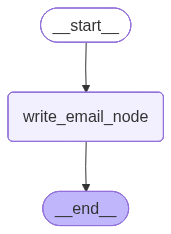

In [37]:
workflow = StateGraph(StateSchema)
workflow.add_node("write_email_node", write_email_node)
workflow.add_edge(START, "write_email_node")
workflow.add_edge("write_email_node", END)

app = workflow.compile()
app

In [38]:
app.invoke(
    {
        "request": "내일 회의에 대해 상사(boss@company.ai)에게 보낼 답변 초안을 작성해 주세요."
    }
)

{'request': '내일 회의에 대해 상사(boss@company.ai)에게 보낼 답변 초안을 작성해 주세요.',
 'email': "Email sent to boss@company.ai with subject '내일 회의 관련 답변' and content: 안녕하세요, 상사님.\n\n내일 회의에 대해 확인하였습니다. 준비된 자료와 안건을 바탕으로 회의에 적극 참여하겠습니다. 혹시 추가로 준비해야 할 사항이나 요청사항이 있으시면 알려주시기 바랍니다.\n\n감사합니다."}

노드 간 라우팅은 간단한 함수를 사용하여 [조건부 엣지(conditional-edges)](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges)로 수행할 수 있습니다.

이 함수의 반환값은 상태를 다음으로 전달할 노드(또는 노드 목록)의 이름으로 사용됩니다. 

선택적으로 `should_continue` 출력을 다음 노드의 이름으로 매핑하는 사전(dictionary)을 제공할 수 있습니다.

In [47]:
from typing import Literal

from langchain_core.messages import ToolMessage

from langgraph.graph import END, START, MessagesState, StateGraph


def call_llm(state: MessagesState):
    output = model_with_tools.invoke(state["messages"])
    return {"messages": [output]}


def run_tool(state: MessagesState):
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        observation = write_email.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


def should_continue(state: MessagesState) -> Literal["run_tool", "__end__"]:
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "run_tool"
    return "__end__"


workflow = StateGraph(MessagesState)
workflow.add_node("call_llm", call_llm)
workflow.add_node("run_tool", run_tool)
workflow.add_edge(START, "call_llm")
workflow.add_conditional_edges(
    "call_llm",
    should_continue,
    {
        "run_tool": "run_tool",
        END: END,
    },
)
workflow.add_edge("run_tool", END)

app = workflow.compile()

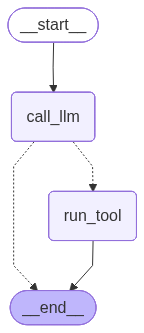

In [48]:
app

In [49]:
from langchain.messages import HumanMessage


result = app.invoke(
    {
        "messages": [
            HumanMessage(
                "상사(boss@company.ai)에게 Interrupt! 행사 참석 의사를 확인하는 회신을 작성해 주세요.",
            )
        ]
    }
)

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

상사(boss@company.ai)에게 Interrupt! 행사 참석 의사를 확인하는 회신을 작성해 주세요.
================================== Ai Message ==================================
Tool Calls:
  write_email (call_YJ2Wl3LZibmcZFvvEOsp1Iqo)
 Call ID: call_YJ2Wl3LZibmcZFvvEOsp1Iqo
  Args:
    to: boss@company.ai
    subject: Interrupt! 행사 참석 의사 확인
    content: 안녕하세요,

Interrupt! 행사 참석 여부를 확인하고자 합니다. 참석 가능하신지 회신 부탁드립니다.

감사합니다.
================================= Tool Message =================================

Email sent to boss@company.ai with subject 'Interrupt! 행사 참석 의사 확인' and content: 안녕하세요,

Interrupt! 행사 참석 여부를 확인하고자 합니다. 참석 가능하신지 회신 부탁드립니다.

감사합니다.


에이전트는 매우 흔한 패턴이기 때문에 LangGraph에는 미리 구축된 에이전트 추상화 기능이 있습니다.

LangGraph의 사전 구축된 메서드를 사용하면 LLM, 도구, 프롬프트만 전달하면 됩니다.

In [50]:
from langgraph.prebuilt import create_react_agent


agent = create_react_agent(
    model="openai:gpt-4.1-mini",
    tools=[write_email],
    prompt="제공된 도구를 사용하여 사용자의 요청에 응답하십시오.",
)

result = agent.invoke(
    {
        "messages": [
            HumanMessage(
                "상사(boss@company.ai)에게 Interrupt! 행사 참석 의사를 확인하는 회신을 작성해 주세요.",
            )
        ]
    }
)

for m in result["messages"]:
    m.pretty_print()

/var/folders/z8/xfx3ln6x16x1fy6q7kpf1tzh0000gn/T/ipykernel_57442/1022834063.py:4: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(


================================ Human Message =================================

상사(boss@company.ai)에게 Interrupt! 행사 참석 의사를 확인하는 회신을 작성해 주세요.
================================== Ai Message ==================================
Tool Calls:
  write_email (call_RG2cFQfbMWCeFCU2E3qB3zOr)
 Call ID: call_RG2cFQfbMWCeFCU2E3qB3zOr
  Args:
    to: boss@company.ai
    subject: Interrupt! 행사 참석 의사 확인
    content: 안녕하세요,

Interrupt! 행사 참석에 대해 의사를 확인 드립니다. 참석 여부를 알려주시면 준비에 참고하겠습니다.

감사합니다.
================================= Tool Message =================================
Name: write_email

Email sent to boss@company.ai with subject 'Interrupt! 행사 참석 의사 확인' and content: 안녕하세요,

Interrupt! 행사 참석에 대해 의사를 확인 드립니다. 참석 여부를 알려주시면 준비에 참고하겠습니다.

감사합니다.
================================== Ai Message ==================================

상사님께 Interrupt! 행사 참석 의사를 확인하는 회신 메일을 작성하여 전송했습니다. 추가로 도와드릴 사항이 있으면 말씀해 주세요.


#### 인터럽트

LangGraph에서는 특정 지점에서 그래프 실행을 중지하기 위해 인터럽트를 사용할 수도 있습니다.

이는 주로 사용자로부터 입력을 수집하고, 수집된 입력으로 실행을 계속하기 위해 사용됩니다.

In [ ]:
from typing import TypedDict

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command, interrupt


class State(TypedDict):
    input: str
    user_feedback: str


def step_1(state: State):
    print("---Step 1")
    pass


def human_feedback(state: State):
    print("---human_feedback---")
    feedback = interrupt("피드백을 제공해 주십시오:")
    return {"user_feedback": feedback}


def step_3(state: State):
    print("---Step 3")
    pass


builder = StateGraph(State)
builder.add_node(step_1)
builder.add_node(human_feedback)
builder.add_node(step_3)
builder.set_entry_point("step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.set_finish_point("step_3")

graph = builder.compile(checkpointer=InMemorySaver())

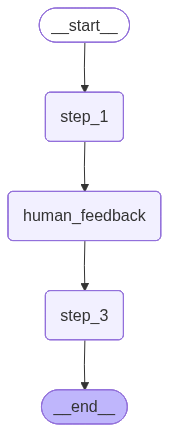

In [52]:
graph

In [53]:
from langchain_core.runnables import RunnableConfig


config = RunnableConfig(configurable={"thread_id": "1"})


for event in graph.stream({"input": "안녕하세요."}, config):
    print(event)
    print("\n")

---Step 1
{'step_1': None}


---human_feedback---
{'__interrupt__': (Interrupt(value='피드백을 제공해 주십시오:', id='54a449ea9759820583acaab191d12c0a'),)}




In [ ]:
for event in graph.stream(Command(resume="step 3으로 이동하세요."), config):
    print(event)
    print("\n")

---human_feedback---
{'human_feedback': {'user_feedback': 'step 3으로 이동하세요.'}}


---Step 3
{'step_3': None}


